In [5]:
"""Training for Grounded SAM.
"""
import os
import torch
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from transformers import SamProcessor

from model import myGroundingDino, myBiomedCLIP, mySAM
import dataset_mimic

# seed
seed_value = 42
import random
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [2]:
hyperparams = {
    "lr": 1e-4,
    "batch_size": 1,
    "num_epochs": 1,
    "num_workers": 4,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "save_folder": "./ckpts/",
}

# Load hyperparameters
lr = hyperparams['lr']
batch_size = hyperparams['batch_size']
num_epochs = hyperparams['num_epochs']
num_workers = hyperparams['num_workers']
device = hyperparams['device']
save_folder = hyperparams['save_folder']

# Load data
num_mimic_batches, mimic_dataloader = dataset_mimic.load_data(batch_size=batch_size, tensor=False, num_workers=num_workers)

# Load model
my_groundingdino = myGroundingDino(
    config_file="./ckpts/GroundingDINO_SwinT_OGC.py",
    ckpt_file="./ckpts/groundingdino_swint_ogc.pth",
    device=device,
)
my_sam = mySAM(
    ckpt_file="./ckpts/sam_vit_l_0b3195.pth",
    device=device,
)
my_biomedclip = myBiomedCLIP(device=device)

# Load optimizer
groundingdino_params = list(my_groundingdino.model.backbone.parameters()) + list(my_groundingdino.img_linear.parameters()) + list(my_groundingdino.txt_linear.parameters())
sam_params = list(my_sam.model.parameters()) + list(my_sam.img_linear.parameters())
optimizer = torch.optim.Adam(groundingdino_params + sam_params, lr=lr)

# Set up training mode
my_groundingdino.model.backbone.train()
my_groundingdino.img_linear.train()
my_groundingdino.txt_linear.train()
my_sam.model.train()
my_sam.img_linear.train()
my_biomedclip.model.eval()

print("done")

final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.d

done


In [6]:
# Training loop
groundingdino_img_similarity_list = []
groundingdino_txt_similarity_list = []
sam_img_similarity_list = []
loss_list = []

for epoch in range(num_epochs):
    
    for i, data in enumerate(tqdm(mimic_dataloader, desc=f'Training @ epoch {epoch+1} of {num_epochs}')):
        optimizer.zero_grad()

        # Load data
        image_paths = data["image_path"]
        reports = data["report"]
        print(reports)
        print("---")

        # Get embeddings
        groundingdino_img_emb = my_groundingdino.get_img_emb(image_paths)
        groundingdino_img_emb = my_groundingdino.align_img_emb(groundingdino_img_emb)
        groundingdino_txt_emb = my_groundingdino.get_txt_emb(reports)
        groundingdino_txt_emb = my_groundingdino.align_txt_emb(groundingdino_txt_emb)

        with torch.no_grad(): # BiomedCLIP is kept frozen
            bmc_img_embedding = my_biomedclip.get_img_emb(image_paths)
            bmc_txt_embedding = my_biomedclip.get_txt_emb(reports)
        
        sam_img_embedding = my_sam.get_img_emb(image_paths)
        sam_img_embedding = my_sam.align_img_emb(sam_img_embedding)

        # Get loss - cosine similarity (consider using InfoNCE loss if we can have larger batch sizes)
        groundingdino_img_similarity = F.cosine_similarity(groundingdino_img_emb, bmc_img_embedding).mean()
        groundingdino_txt_similarity = F.cosine_similarity(groundingdino_txt_emb, bmc_txt_embedding).mean()
        sam_img_similarity = F.cosine_similarity(sam_img_embedding, bmc_img_embedding).mean()
        loss = -(groundingdino_img_similarity + groundingdino_txt_similarity + sam_img_similarity)
        
        # Logging
        groundingdino_img_similarity_list.append(groundingdino_img_similarity.item())
        groundingdino_txt_similarity_list.append(groundingdino_txt_similarity.item())
        sam_img_similarity_list.append(sam_img_similarity.item())
        loss_list.append(loss.item())
        print(groundingdino_img_similarity.item(), groundingdino_txt_similarity.item(), sam_img_similarity.item(), loss.item())

        # Training step
        loss.backward()
        optimizer.step()
        if i % 101 == 0:
            # Save model
            my_groundingdino.save_model(
                ckpt_folder=save_folder,
                backbone_ckpt="initial_experiments_groundingdino_backbone.pth",
                img_linear_ckpt="initial_experiments_groundingdino_img_linear.pth",
                txt_linear_ckpt="initial_experiments_groundingdino_txt_linear.pth",
            )
            my_sam.save_model(
                ckpt_folder=save_folder,
                backbone_file="initial_experiments_sam.pth",
                img_linear_ckpt="initial_experiments_sam_img_linear.pth",
            )


Training @ epoch 1 of 1:   0%|          | 0/316437 [00:02<?, ?it/s]

torch.Size([1, 195, 256])
torch.Size([1, 512])
---
0.821410059928894 0.7238520383834839 0.7825764417648315 -2.32783842086792
torch.Size([1, 195, 256])
torch.Size([1, 512])
---
0.7521257996559143 0.7545442581176758 0.7181984186172485 -2.2248682975769043
torch.Size([1, 195, 256])
torch.Size([1, 512])
---
0.8723499774932861 0.8384664058685303 0.8723244667053223 -2.5831408500671387
torch.Size([1, 195, 256])
torch.Size([1, 512])
---
0.9034265875816345 0.8890319466590881 0.901878833770752 -2.6943373680114746
torch.Size([1, 195, 256])
torch.Size([1, 512])
---
0.823986828327179 0.7509260177612305 0.7957549095153809 -2.3706676959991455
torch.Size([1, 195, 256])
torch.Size([1, 512])
---
0.8648597002029419 0.5948745012283325 0.8614271879196167 -2.3211612701416016
torch.Size([1, 195, 256])
torch.Size([1, 512])
---
0.8947035074234009 0.7339193224906921 0.8966648578643799 -2.525287628173828
torch.Size([1, 195, 256])
torch.Size([1, 512])
---
0.9235612154006958 0.7460058927536011 0.923575758934021 -2.

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x51712 and 49920x512)

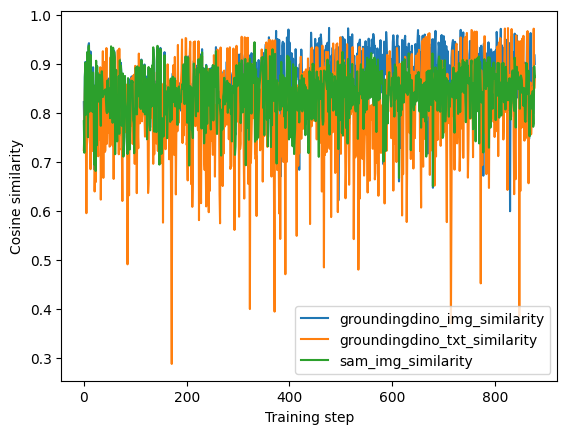

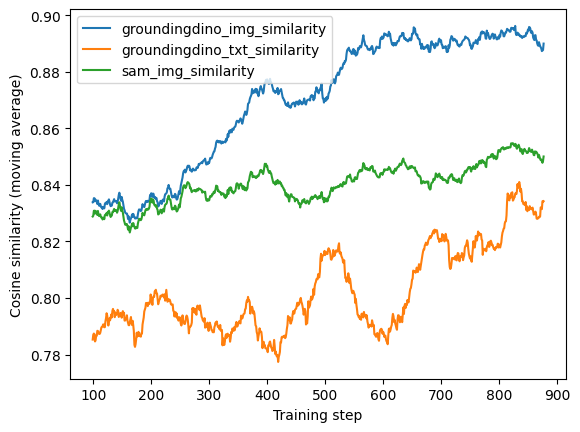

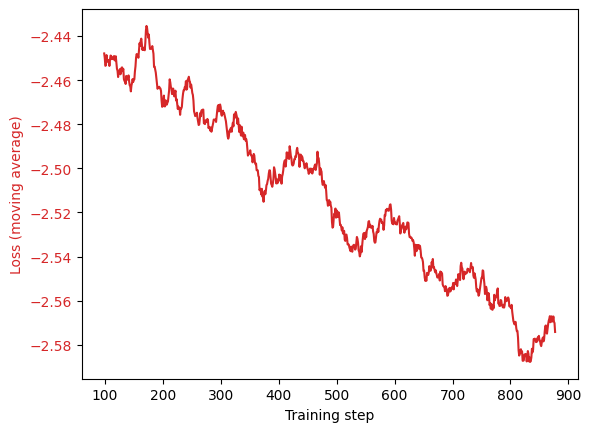

In [10]:
import matplotlib.pyplot as plt
plt.plot(groundingdino_img_similarity_list)
plt.plot(groundingdino_txt_similarity_list)
plt.plot(sam_img_similarity_list)
plt.legend(["groundingdino_img_similarity", "groundingdino_txt_similarity", "sam_img_similarity"])
plt.xlabel("Training step"); plt.ylabel("Cosine similarity")
plt.show()
# plt.plot(loss_list)

# Plot moving average
window_size = 100
groundingdino_img_similarity_list = np.array(groundingdino_img_similarity_list)
groundingdino_txt_similarity_list = np.array(groundingdino_txt_similarity_list)
sam_img_similarity_list = np.array(sam_img_similarity_list)
loss_list = np.array(loss_list)
plt.plot(pd.Series(groundingdino_img_similarity_list).rolling(window_size).mean())
plt.plot(pd.Series(groundingdino_txt_similarity_list).rolling(window_size).mean())
plt.plot(pd.Series(sam_img_similarity_list).rolling(window_size).mean())
plt.legend(["groundingdino_img_similarity", "groundingdino_txt_similarity", "sam_img_similarity"])
plt.xlabel("Training step"); plt.ylabel("Cosine similarity (moving average)")
plt.show()

# Plot loss moving average on a separate y axis
fig, ax1 = plt.subplots()
ax1.plot(pd.Series(loss_list).rolling(window_size).mean(), color='tab:red')
ax1.set_xlabel('Training step')
ax1.set_ylabel('Loss (moving average)', color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')


In [13]:
import matplotlib.pyplot as plt

# Sample data (you have this already)
window_size = 100
groundingdino_img_similarity_list = np.array(groundingdino_img_similarity_list)
groundingdino_txt_similarity_list = np.array(groundingdino_txt_similarity_list)
sam_img_similarity_list = np.array(sam_img_similarity_list)
loss_list = np.array(loss_list)

# Create main figure and axis
fig, ax1 = plt.subplots()

# Plot similarities on the main axis
ax1.plot(pd.Series(groundingdino_img_similarity_list).rolling(window_size).mean())
ax1.plot(pd.Series(groundingdino_txt_similarity_list).rolling(window_size).mean())
ax1.plot(pd.Series(sam_img_similarity_list).rolling(window_size).mean())
ax1.set_xlabel("Training step")
ax1.set_ylabel("Cosine similarity (moving average)")
# ax1.legend(["groundingdino_img_similarity", "groundingdino_txt_similarity", "sam_img_similarity"])
ax1.legend(["groundingdino_img_similarity", "groundingdino_txt_similarity", "sam_img_similarity"], 
           loc='bottom', bbox_to_anchor=(1, 1))

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()
ax2.plot(pd.Series(loss_list).rolling(window_size).mean(), color='tab:red')
ax2.set_ylabel('Loss (moving average)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Show the plot
plt.show()


## Functions

In [ ]:
def train_adaptation(hyperparams):
    """Training script for adaptation loss only (to be combined with segmentation objective).
    """
    # Load hyperparameters
    lr = hyperparams['lr']
    batch_size = hyperparams['batch_size']
    num_epochs = hyperparams['num_epochs']
    num_workers = hyperparams['num_workers']
    device = hyperparams['device']
    save_folder = hyperparams['save_folder']


    # Load data
    mimic_dataloader = dataset_mimic.load_data(batch_size=batch_size, tensor=True, num_workers=num_workers)

    # Load model
    my_groundingdino = myGroundingDino(
        config_file="./ckpts/GroundingDINO_SwinT_OGC.py",
        ckpt_file="./ckpts/groundingdino_swint_ogc.pth",
        device=device,
    )
    my_sam = mySAM(
        ckpt_file="./ckpts/sam_vit_l_0b3195.pth",
        device=device,
    )
    my_biomedclip = myBiomedCLIP(device=device)

    # Load optimizer
    groundingdino_params = list(my_groundingdino.model.backbone.parameters()) + list(my_groundingdino.img_linear.parameters()) + list(my_groundingdino.txt_linear.parameters())
    sam_params = list(my_sam.model.parameters()) + list(my_sam.img_linear.parameters())
    optimizer = torch.optim.Adam(groundingdino_params + sam_params, lr=lr)

    # Set up training mode
    my_groundingdino.model.backbone.train()
    my_groundingdino.img_linear.train()
    my_groundingdino.txt_linear.train()
    my_sam.model.train()
    my_sam.img_linear.train()
    my_biomedclip.model.eval()

    # Training loop
    for epoch in range(num_epochs):
        
        for data in tqdm(mimic_dataloader, desc=f'Training @ epoch {epoch+1} of {num_epochs}'):
            # Load data
            images = data["image"]
            image_paths = data["image_path"]
            report = data["report"]

            # # Training step
            # optimizer.zero_grad()
            # loss = pass
            # loss.backward()
            # optimizer.step()
    
    # Save model
    my_groundingdino.save_model(ckpt_folder=save_folder)
    my_sam.save_model(ckpt_folder=save_folder)


hyperparams = {
    "lr": 1e-4,
    "batch_size": 16,
    "num_epochs": 1,
    "num_workers": 4,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "save_folder": "./ckpts/",
}

train_adaptation(hyperparams)